# Automated Categorisation of Product Listings

## I Introduction

### 1. Domain-Specific Area

Text classification plays a fundamental role in organising large numbers of available products for e-commerce platforms. In online retail, cast product inventories require efficient organisation and classification to enhance user experience and to streamline the process for the store staff and management. Text classification methods could offer a solution to this challenge by suggesting categories for a product, or even automatically categorising products based on their description. This project will attempt to address the challenge of automating and enhancing the product categorisation process using text classification techniques. Specifically the goal is to accurately assign product descriptions from the product's selling page, to a set of predefined categories, like "Electronic", "Books", "Clothing", etc.

Efficient text classification will significantly reduce manual effort from staff (and possibly users) in product categorisation and enhance search accuracy for the users. By automating the categorisation process based on the product's description, this project will attempt to optimise catalog management and organisation.

In the context of competitive online markets, accurate product categorisation can influence customer engagement and retention and is therefore essential to an online store. For these reasons this projects domain-specific application in e-commerce holds a substantial amount of potential to streamline operations, improve user interactions, and to provide a competitive edge to online retailers in delivering relevant and possibly even tailored product experiences.

### 2. Objectives

The main objective of this project is to develop a robust product classification model, that is capable of accurately categorising product description into predefined classes related to the e-commerce domain. By achieving this objective, the project aims to optimise the product categorisation process, by reducing and speeding up manual labour and automating the organisation of large numbers of available products. The ultimate end goal would be to enhance the user experience by being able to provide more accurate search results and personalised recommendations based on the product descriptions, however that is beyond the current scope of the project.

This project's objectives align with the overarching goal of improving the efficiency and accuracy of online retail platforms by minimising human effort in catalog management. The outcomes of this project hold the potential to demonstrate the effectiveness and potential of automated systems, like automated product categorisation approaches.

In short, this project will need to accurately assign product descriptions that would be available on a seller's page, to one of these four categories from the identified dataset:
- "Electronics"
- "Household"
- "Books"
- "Clothing & Accessories"

If this model shows promise, the amount of categories and even sub categories could potentially be future additions.

### 3. Dataset

Dataset Characteristics:
- **Size** - The dataset consists of a collection of 50 425 entries.
- **Data Types / Structure** - The dataset consist of a singular CSV file with two string columns. The file lacks a header row, but based off of the description, the first column contains the class name, and the second column the product description. There are four possible classes that a product can belong to
- **Data Source** - The dataset was accessed via Kaggle at [this link](https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification). It was posted by a user "Saurabh Shahane" who based the dataset off of [this dataset](https://zenodo.org/records/3355823) from Zenodo.


### 4. Evaluation Methodology

For evaluating the performance of the text classification model, we will use the following metrics:

1. **Accuracy:** 
   - This metric measures the overall correctness of the model's predictions.
   - It represents the percentage of correctly classified descriptions in the test data.

2. **Precision and Recall:** 
   - **Precision:** Measures the accuracy of positive predictions. It indicates the proportion of correctly predicted positive instances out of all instances predicted as positive.
   - **Recall:** Measures the ability of the model to find all the positive instances. It shows the proportion of correctly predicted positive instances out of all actual positive instances.

Accuracy should give use a rough idea of how well the model performed. However the problem with accuracy is the fact that an unbalanced dataset could result in an inaccurate evaluation of the performance. For this reason it is important to also calculate precision and recall, which should give accurate results, even when the dataset is unbalanced.

The metrics calculated from the model's performance, will be compared against a **baseline** to determine if the developed model performs significantly better than a basic approach. This helps in understanding the model's effectiveness.

By using these simpler evaluation metrics and comparing against a baseline, we can effectively gauge the performance of the model in classifying product descriptions across multiple categories.

## II Implementation

In [2]:
%%capture
# Install the required packages
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib

### 5. Preprocessing

The dataset is in the form of a two column, CSV file.

In [3]:
import pandas as pd

# Load the dataset
file_path = "./data/ecommerceDataset.csv"
all_data = pd.read_csv(file_path, header=None, names=["Category", "Description"])

all_data.head()

,Category,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [4]:
# Check for missing values
all_data.isnull().sum()

Category       0
Description    1
dtype: int64

The dataset has missing data. The dataset is fortunately large enough that simply removing the entries with missing values will still leave a large enough dataset to work with.

In [5]:
all_data.dropna(inplace=True)

In [6]:
num_entries = all_data.shape[0]
print("Number of entries in the dataframe:", num_entries)

Number of entries in the dataframe: 50424


The dataset is very large. This causes a significant slowdown and long training times during development, as the hardware that is being used is not that powerful. For this reason I will only be sampling 25 000 random entries (50% of total data) from the dataset, to make it more manageable to work with.

The random state is also assigned to ensure that I am able to consistently recreate results.

In [7]:
RANDOM_STATE = 16

sampled_data = all_data.sample(n=25000, random_state=RANDOM_STATE)
sampled_data.reset_index(drop=True, inplace=True)

In [8]:
print("Number of entries per category\n" + "-" * 32)

sampled_data["Category"].value_counts()

Number of entries per category
--------------------------------


Household                 9504
Books                     5870
Electronics               5321
Clothing & Accessories    4305
Name: Category, dtype: int64

In [9]:
categories = list(sampled_data["Category"].unique())
print("The possible product categories are:" + "".join(["\n- " + c for c in categories]))

The possible product categories are:
- Books
- Electronics
- Household
- Clothing & Accessories


In [10]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Remove any possible symbols that would be in the text
def remove_symbols(text):
    return re.sub(r"[^\w\s]", "", text)

# Remove the stopwords from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]  # Remove stopwords
    return " ".join(filtered_words)  # Join the words back into one string

def filter_text(text):
    text = remove_symbols(text)
    text = remove_stopwords(text)
    return text

sampled_data["Description"] = sampled_data["Description"].apply(filter_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KarelKat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Splitting the data into a training and test set. It is split to be 20% test data and 80% training data.

In [11]:
from sklearn.model_selection import train_test_split

X = sampled_data["Description"]
y = sampled_data["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### 6. Baseline Performance

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Helper function to calculate accuracy, precision and recall
def get_predict_stats(test_data, predictions):
    predict_accuracy = accuracy_score(test_data, predictions)
    predict_precision = precision_score(test_data, predictions, average="weighted", zero_division=0)
    predict_recall = recall_score(test_data, predictions, average="weighted", zero_division=0)
    return { 
        "predict_accuracy": predict_accuracy, 
        "predict_precision": predict_precision, 
        "predict_recall": predict_recall 
    }

In order to measure if the model developed is good, a baseline performance is calculated to use as a reference point. The very simplest method for a baseline would involve picking a random label, resulting in a 25% (1/4) chance of being correct if the dataset is evenly divided. These odds can however be improved, even without using a complex model. Instead the model implemented will need to beat a slightly more complex baseline as well. The advanced baseline will work by selecting the product category that appears most often, and then use that category as the predicted category for all product descriptions in the test set. This method serves as an educated guess, rather than randomly selecting a label.

In [13]:
import random

# Seed the random methods to ensure consistent and repeatable results
random.seed(RANDOM_STATE)

def random_category():
    return random.choice(categories)

# Find and return most populated class in the data
def most_common_category(data):
    count_per_category = dict(data["Category"].value_counts())
    max_key = max(count_per_category, key=count_per_category.get)
    return max_key


print("Baseline Precision and Recall:\n" + "-" * 30)
# Precision and Recall for Random Baseline
print("Random Baseline:")
random_predictions = [random_category() for _ in range(len(y_test))]
random_stats = get_predict_stats(y_test, random_predictions)
print(f"  Accuracy: {(random_stats['predict_accuracy'] * 100):.2f}%")
print(f"  Precision: {(random_stats['predict_precision'] * 100):.2f}%")
print(f"  Recall: {(random_stats['predict_recall'] * 100):.2f}%")

# Precision and Recall for Most Frequent Baseline
print("\nMost Frequent Class Baseline:")
most_common_class = most_common_category(sampled_data)
frequent_predictions = [most_common_class for _ in range(len(y_test))]
frequent_stats = get_predict_stats(y_test, frequent_predictions)
print(f"  Accuracy: {(frequent_stats['predict_accuracy'] * 100):.2f}%")
print(f"  Precision: {(frequent_stats['predict_precision'] * 100):.2f}%")
print(f"  Recall: {(frequent_stats['predict_recall'] * 100):.2f}%")

Baseline Precision and Recall:
------------------------------
Random Baseline:
  Accuracy: 24.80%
  Precision: 27.07%
  Recall: 24.80%

Most Frequent Class Baseline:
  Accuracy: 37.54%
  Precision: 14.09%
  Recall: 37.54%


### 7. Classification Approach

The purpose of the model is to categorise products based on their descriptions. The "Description" column is utilised as the feature ("X") while the "Category" column serves as the label / category ("y"). This selection was made with the assumption that the product description would carry some valuable information relating to the type of product it is.

For the model, the Naïve Bayes algorithm was selected, specifically "MultinomialNB" from the "sklearn" library. This approach should be effective to classify data into multiple classes.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Set up the model pipeline
# The product descriptions will be vectorised into numerical features to allow
#  us to use Naive Bayes to calculate which product class should be selected
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [15]:
# Apply the training data to model and predict from test data
model.fit(X_train, y_train)
predicted_categories = model.predict(X_test)

## III Conclusion

### 8. Evaluation

The confusion matrix will illustrates the model's performance across different categories

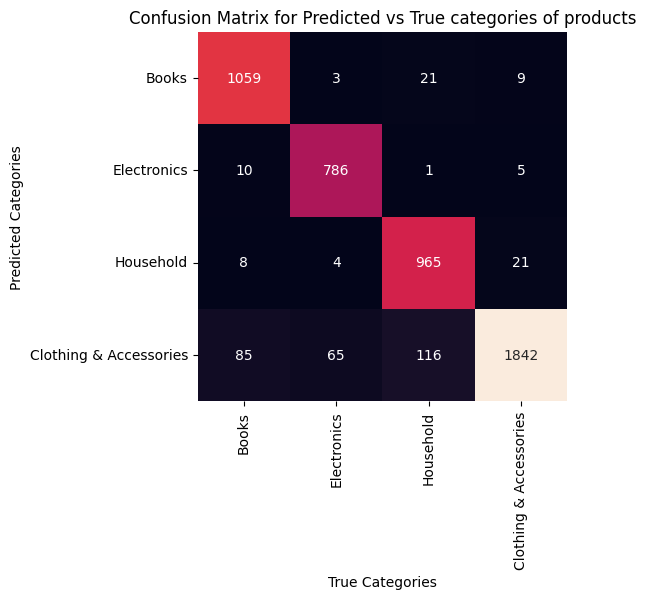



Category incorrectly labelled the most: Clothing & Accessories
Category incorrectly predicted the most: Household


In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, predicted_categories)
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
plt.xlabel("True Categories")
plt.ylabel("Predicted Categories")
plt.title("Confusion Matrix for Predicted vs True categories of products")
plt.show()



conf_matrix_df = pd.DataFrame(conf_matrix, index=categories, columns=categories)
# Fill diagonal elements (correctly predicted) with zeros to prevent correct identifications from being counted
np.fill_diagonal(conf_matrix_df.values, 0)

most_labelled_category = conf_matrix_df.sum(axis=0).idxmax()
most_incorrect_category = conf_matrix_df.sum(axis=1).idxmax()

print("\n")
print("Category incorrectly labelled the most:", most_labelled_category)
print("Category incorrectly predicted the most:", most_incorrect_category)

As can be seen from the confusion matrix, the model does correctly identify most products. Something to note is that it does often incorrectly categorise products as "Clothing & Accessories". This could possibly be due to accessories covering a large variety of items that could confuse the model. Another possible explanation could be due to a lack of training data. On the other hand, "Household" category predictions are the least accurate according to the confusion matrix. The model often confuses "Household" for "Clothing & Accessories"

In [17]:
model_stats = get_predict_stats(y_test, predicted_categories)
print("Evaluating Model Performance:\n" + "-" * 30)
print("Best Baseline (Most Frequent Class):")
print(f"Accuracy: {(frequent_stats['predict_accuracy'] * 100):.2f}%")
print(f"Precision: {(frequent_stats['predict_precision'] * 100):.2f}%")
print(f"Recall: {(frequent_stats['predict_recall'] * 100):.2f}%")

print("\nModel:")
print(f"Accuracy: {(model_stats['predict_accuracy'] * 100):.2f}%")
print(f"Precision: {(model_stats['predict_precision'] * 100):.2f}%")
print(f"Recall: {(model_stats['predict_recall'] * 100):.2f}%")

Evaluating Model Performance:
------------------------------
Best Baseline (Most Frequent Class):
Accuracy: 37.54%
Precision: 14.09%
Recall: 37.54%

Model:
Accuracy: 93.04%
Precision: 93.49%
Recall: 93.04%


The baseline model serves as a benchmark for comparison.

The developed model significantly outperformed the baseline in all metrics, showcasing its effectiveness in classifying product categories based on their descriptions.

The evaluation metrics illustrate that the developed model, utilizing the Naïve Bayes algorithm with TF-IDF vectorization, performs significantly better than the baseline approach. It demonstrates high accuracy, precision, and recall, indicating its efficacy in categorizing product descriptions into respective classes.

### 9. Summary and Conclusion

This project set out to address the challenge of automating and refining the product categorisation process within e-commerce, using text classification. Accurate text classification can help to reduce the total manual work load required to categorise large catalogs of products. This project showed that it is possible to accurately and efficiently classify products based on the already existing product description, in order to achieve this. This benefit could also extend to the end user or customer, by possibly providing more appropriate search results and to streamline the operations's efficiency. The contribution made by this project is in showing that implementing an automated system like this is not only possible, but also effective.

The approach used in this project, was Naïve Bayes with TF-IDF vectorization. As for the input data used, not too much pre-processing was required, aside from removing symbols, stopwords and any blank or missing entries. This approach could easily be applied on other domains that require some form of text categorisation as well. The methods used were able to distinguish between both similar and vastly different types of categories, showing its adaptability. While the techniques should be easily transferable to a different programming language / environment is possible, the specific implementation in this project heavily relies on using external libraries, varying from loading the training data, to the model itself. For this reason a one to one conversion would be impossible, unless other similar libraries exist in the desired programming language.

The methods that were used in this project was able to produce a satisfactory results, however it is not perfect. Alternative methods could possible result in a better model. One example of an alternative approach might be some form of Neural Network. A model like this is much more complex, and could possibly result in a better performing model at the end, but there are some problems. Training a neural network is much more intensive than training a simple model like this, so more processing power will be needed. Additionally, these models require a lot more tuning, to prevent problems such as overfitting.

In conclusion, the project managed to achieve the goal it set out to do, by developing a relatively accurate text classification model, capable of automatically categorising products.